In [1]:
import numpy as np
import pandas as pd
import json
import re

In [9]:
transcripts_df = pd.read_csv('annotated_transcirpts_117C_v3.csv')

In [10]:
import os

# show the size of annotated_transcirpts_117C_v3.csv
os.path.getsize('annotated_transcirpts_117C_v3.csv')

1846825944

In [11]:
os.path.getsize('glove.6B.100d.txt')

347116733

In [3]:
CLEANR = re.compile('<.*?>')
CLEANR2 = re.compile('[.*?]')
CLEANR3 = re.compile("s+")

In [4]:
def clean_text(text):
    temp = re.sub(CLEANR, '', text)
    temp = re.sub(CLEANR2, '', temp)
    temp = temp.replace('\n', ' ')
    temp = re.sub(CLEANR3, ' ', temp).strip()
    temp = temp.lower()
    return temp

In [5]:
transcripts_df['transcript'] = transcripts_df['transcript'].apply(clean_text)

In [6]:
transcripts_df.head()

,Unnamed: 0,meta,transcript,date_x,bill_number,congress,chamber,rollnumber,date_y,session,...,nay_count,nominate_mid_1,nominate_mid_2,nominate_spread_1,nominate_spread_2,nominate_log_likelihood,vote_result,vote_desc,vote_question,dtl_desc
0,148,"{'body': 'H', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 12 (wedne...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
1,156,"{'body': 'S', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 8 (wedne ...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
2,164,"{'body': 'S', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 7 (tue da...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
3,172,"{'body': 'S', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 7 (tue da...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
4,180,"{'body': 'H', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 48 (thur ...",2022-03-24,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN


In [7]:
# Load the glove mode
vec_txt_file_lines = open('glove.6B.100d.txt', 'r', encoding="utf8").readlines()

glove = {}

for line in vec_txt_file_lines:
    line_split = line.split(' ')
    key = line_split[0]
    vec = np.array([float(v) for v in line_split[1:]])
    glove[key] = vec

In [8]:
X_naive_mean = []
Y_naive_mean_yea = []
Y_naive_mean_passed = []

for i, row in transcripts_df.iterrows():
    tx_vecs = []
    for w in row['transcript'].split(' '):
        if w in glove:
            tx_vecs.append(glove[w])

    X_naive_mean.append(np.mean(tx_vecs, axis=0))
    Y_naive_mean_yea.append(row['yea_count'])
    Y_naive_mean_passed.append(True if row['vote_result'] == 'Passed' else False)

KeyboardInterrupt: 

In [12]:
# prompt: save X_naive_mean, Y_naive_mean_yea, Y_naive_mean_passed with pickle

import pickle
with open('X_naive_mean.pickle', 'wb') as f:
    pickle.dump(X_naive_mean, f)

with open('Y_naive_mean_yea.pickle', 'wb') as f:
    pickle.dump(Y_naive_mean_yea, f)

with open('Y_naive_mean_passed.pickle', 'wb') as f:
    pickle.dump(Y_naive_mean_passed, f)


In [19]:
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_yea, test_size=0.2, random_state=42)

model = LinearSVC(class_weight='balanced').fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred)**0.5)

C:\Users\Ezra\AppData\Local\pypoetry\Cache\virtualenvs\cs505-final-project-NukGPjlo-py3.9\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.015455776173285198
119.93808289045154


C:\Users\Ezra\AppData\Local\pypoetry\Cache\virtualenvs\cs505-final-project-NukGPjlo-py3.9\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9020758122743683


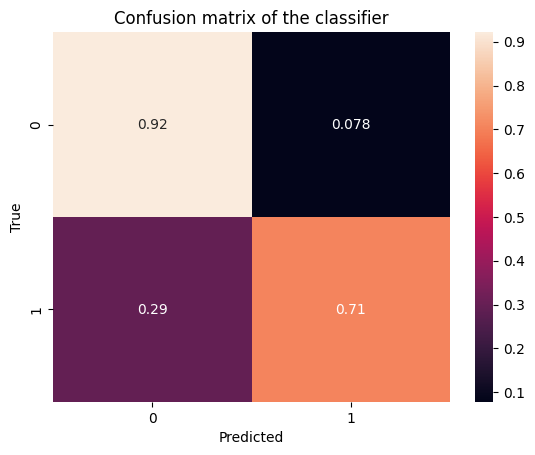

In [21]:
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.2, random_state=42)

model = SGDClassifier(
    class_weight='balanced',
    loss='log_loss',
    alpha=0.00001
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

C:\Users\Ezra\AppData\Local\pypoetry\Cache\virtualenvs\cs505-final-project-NukGPjlo-py3.9\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Ezra\AppData\Local\pypoetry\Cache\virtualenvs\cs505-final-project-NukGPjlo-py3.9\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.86838146811071


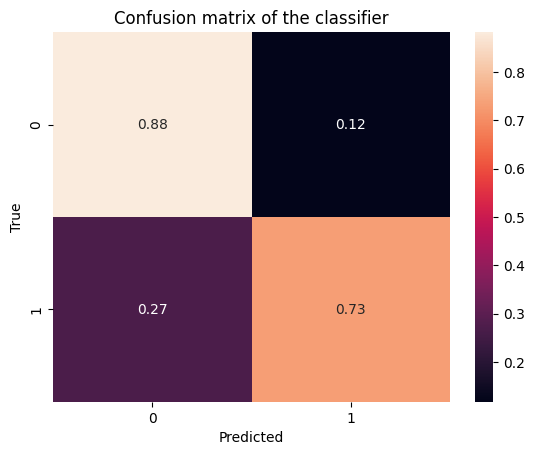

In [22]:
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.3, random_state=42)

model = LinearSVC(
    class_weight='balanced'
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
set(y_pred)

{False, True}

In [24]:
from xgboost import XGBClassifier, XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_yea, test_size=0.2, random_state=42)

bst = XGBRegressor(n_estimators=200, learning_rate=0.1)
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
print(mean_squared_error(y_test, y_pred)**0.5)

52.22124288506633


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.2, random_state=42)

bst = XGBClassifier(n_estimators=100, max_depth=150, learning_rate=1, objective='binary:logistic')

bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)

0.9448330324909747


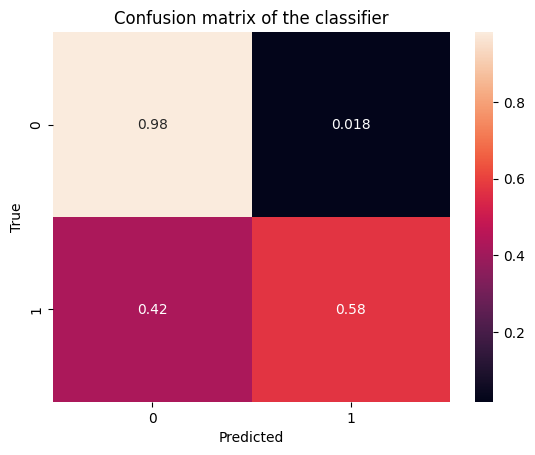

In [26]:
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# use a simple NN to predict the number of yea votes
# just 5 stacked dense layers

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

# train to predict the number of yea votes given the transcript embedding

model.compile(loss='mean_squared_error', optimizer=Adam())

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_yea, test_size=0.2, random_state=42)

model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size=32, verbose=1)

In [13]:
# lets get the average, std, etc of the number of yea votes from the whole dataset (transcripts_df)

transcripts_df['yea_count'].describe()

count    44319.000000
mean       221.949006
std         56.704273
min         78.000000
25%        208.000000
50%        218.000000
75%        226.000000
max        432.000000
Name: yea_count, dtype: float64

In [ ]:
# that model didn't work. let's try a pass-fail classifier instead.

classifier_model = Sequential()
classifier_model.add(Dense(100, input_dim=100, activation='relu'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(100, activation='relu'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(100, activation='relu'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(100, activation='relu'))
classifier_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# train it with new split based on naive_mean_passed

classifier_model.compile(loss='binary_crossentropy', optimizer=Adam())

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.2, random_state=42)


In [ ]:

# compute class weights

weight_for_false = (1 / len([x for x in y_train if x==False])) * (len(y_train)) / 2.0
weight_for_true = (1 / len([x for x in y_train if x==True])) * (len(y_train)) / 2.0


y_train = [int(x) for x in y_train]

class_weight = {0: weight_for_false, 1: weight_for_true}
class_weight

In [ ]:

classifier_model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size=32, verbose=1,
                     class_weight=class_weight
                     )

In [ ]:
# eval suite

y_pred = classifier_model.predict_on_batch(np.array(X_test))

y_pred_bool = [x[0] > 0.5 for x in y_pred]


# accuracy & confusion matrix

print(round(accuracy_score(y_test, y_pred_bool), 2))
cm = confusion_matrix(y_test, y_pred_bool, normalize='true')

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the Neural Net based classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()